In [1]:
#Import libraries for simulation
#import tensorflow as tf
import numpy as np

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import time

#Imports for visualization
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display


def DisplayArray(a, fmt='jpeg', rng=[0,1]):
    """Display an array as a picture."""
    a = (a - rng[0])/float(rng[1] - rng[0])*255
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    clear_output(wait = True)
    display(Image(data=f.getvalue()))

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def make_kernel(a):
    """Transform a 2D array into a convolution kernel"""
    a = np.asarray(a)
    a = a.reshape(list(a.shape) + [1,1])
    return tf.constant(a, dtype=1)

def simple_conv(x, k):
    """A simplified 2D convolution operation"""
    x = tf.expand_dims(tf.expand_dims(x, 0), -1)
    y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
    return y[0, :, :, 0]

In [3]:
def laplace_iso(x):
    """Compute the 2D laplacian of an array"""
    laplace_k = make_kernel([[0.25, 0.5, 0.25],
                           [0.5, -3., 0.5],
                           [0.25, 0.5, 0.25]])
    return simple_conv(x, laplace_k)
def laplace(x):
    """Compute the 2D laplacian of an array"""
    laplace_k = make_kernel([[0., 1., 0.],
                           [1., -4., 1.],
                           [0., 1., 0.]])
    return simple_conv(x, laplace_k)

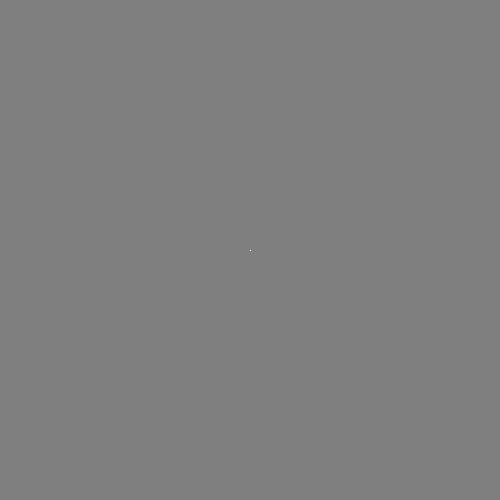

In [4]:
N = 500

# Set everything to zero
u_init = np.zeros([N, N], dtype=np.float32)
ut_init = np.zeros([N, N], dtype=np.float32)

u_init[N//2,N//2] = 10.

DisplayArray(u_init, rng=[-0.1, 0.1])

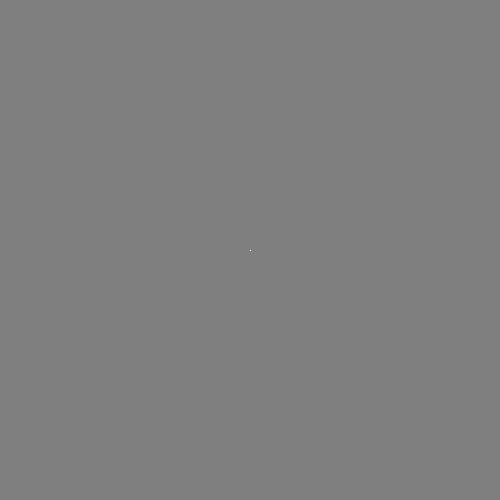

In [5]:
N = 500

# Set everything to zero
u_init = np.zeros([N, N], dtype=np.float32)
ut_init = np.zeros([N, N], dtype=np.float32)

u_init[N//2,N//2] = 10.

DisplayArray(u_init, rng=[-0.1, 0.1])

In [6]:
sess = tf.InteractiveSession()
#sess = tf.compat.v1.Session()

In [7]:
# Parameters:
# eps -- time resolution
# damping -- wave damping
# c -- wave speed 
eps = tf.placeholder(tf.float32, shape=())
damping = tf.placeholder(tf.float32, shape=())
c = tf.placeholder(tf.float32, shape=())

# Create variables for simulation state
U  = tf.Variable(u_init)
Ut = tf.Variable(ut_init)

# Discretized PDE update rules
U_ = U + eps * Ut
Ut_ = Ut + eps * ((c ** 2) * laplace(U) - damping * Ut)

# Operation to update the state
step = tf.group(
    U.assign(U_),
    Ut.assign(Ut_))

# Initialize state to initial conditions
tf.global_variables_initializer().run()

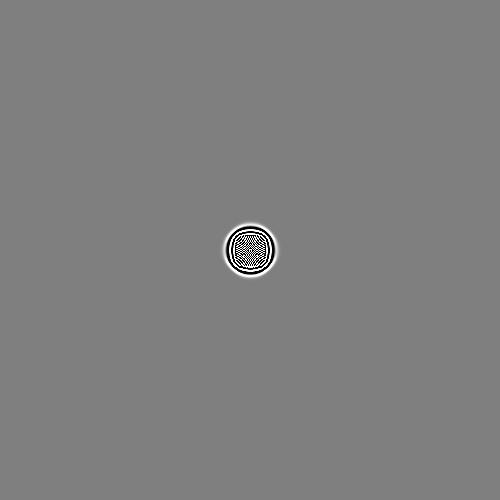

3.6636433601379395


In [8]:
# Run 1000 steps of PDE
start = time.time()
for i in range(300):
    # Step simulation
    step.run({eps: 0.03, damping: 0.04, c: 3.0})
    DisplayArray(U.eval(), rng=[-0.1, 0.1])

elapsed = time.time() - start
print(elapsed)
sess.close()